In [1]:
# Import required modules 
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import os 
import matplotlib.lines as mlines
from datetime import datetime
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
import gsw # Gibbs-SeaWater (GSW) Oceanographic Toolbox 

### Import data and define variables 

In [2]:
# Figure 3A - Bed & Ice Surface Elevation (BedMachine v5) & Terminus Position
KBC_bed_machine = pd.read_csv('R:/KOGE_BUGT/github/data/BedMachine_profiles/150m/KBC_bed_elevation_150m.csv') 
KBC_distance = KBC_bed_machine['distance']
KBC_bed_elevation = KBC_bed_machine['bed']
KBC_surface_elevation = KBC_bed_machine['surface']
KBC_surface_elevation.replace(0, np.nan, inplace=True)
KBC_terminus_timeseries = pd.read_csv('R:/KOGE_BUGT/github/data/terminus_position_along_flowline/koge_bugt_C_TP_distance_along_flowline.csv')
KBC_terminus_timeseries['Date'] = pd.to_datetime(KBC_terminus_timeseries['Date'], format='%d/%m/%Y')
KBC_terminus_timeseries['DOY'] = KBC_terminus_timeseries['Date'].dt.dayofyear 
KBC_terminus_timeseries['Year'] = KBC_terminus_timeseries['Date'].dt.year

start_year = 2016
end_year = 2024
scale_start = 2
scale_end = 10
years = np.arange(start_year, end_year + 1)
scale_values = np.linspace(scale_start+1.2, scale_end-0.6, len(years))
year_offsets = dict(zip(years, scale_values))
day_scale = 0.7 

KBC_SITES = {'T': (11476.485, 195.38565063476562, '#f77f00'),
             'T3': (8476.485, 427.3382568359375, '#a30b37'),
             'T6': (5476.485, 644.4671630859375, '#219ebc'),
             'T9': (2476.627, 868.2918090820312, '#10678e')}

In [3]:
# Figure 3B - Terminus Position 
KBC_terminus = pd.read_csv(r"R:/KOGE_BUGT/github/data/MaQiT_terminus_position_change/koge_bugt_C_maqit_output_2015_2024.csv", skiprows=1, parse_dates= {"Date" : ["Year","Month","Day"]})
KBC_terminus.sort_values(by='Date', ascending = True, inplace = True) 
KBC_january_2016_index = KBC_terminus.index[KBC_terminus['Date'] == '2016-01-12'].tolist()
KBC_terminus['TP_RELATIVE_TO_JAN_2016'] = KBC_terminus['Terminus Position on flowline'] - KBC_terminus['Terminus Position on flowline'].iloc[KBC_january_2016_index[0]]
KBC_jan_2016_label = KBC_terminus['Date'].iloc[11].strftime('%d/%m/%Y')

def y_fmt(x, pos): # Define a function to format the y-axis labels so positive values are prefixed with a '+' sign.
    return f'{x:+.1f}'

In [4]:
# Figure 3C - Ice Discharge (Mankoff et al., 2020)
KBC_discharge_df = pd.read_csv('R:/KOGE_BUGT/github/data/mankoff_2020_ice_discharge/koge_bugt_C_ice_discharge.csv')
KBC_discharge_error = KBC_discharge_df['Error']
KBC_discharge = KBC_discharge_df['Discharge']
KBC_discharge_date = KBC_discharge_df['Date']
KBC_discharge_date = pd.to_datetime(KBC_discharge_date)
date_mask = (KBC_discharge_df['Date'] >= '2016-01-01') & (KBC_discharge_df['Date'] <= '2024-01-01')
mean_discharge = KBC_discharge_df.loc[date_mask, 'Discharge'].mean() # Calculate the mean ice discharge between 2016 and 2024.

In [5]:
# Figure 3D - Ice Velocity (ITS_LIVE)
KBC_velocity_directory = "R:/KOGE_BUGT/github/data/ITS_LIVE_velocity_fahnestock_widget/koge_bugt_central/"
for filename in os.listdir(KBC_velocity_directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(KBC_velocity_directory, filename)
        df = pd.read_csv(file_path)
        df_filtered = df[df[' dt (days)'] <= 12] # Remove any rows where the seperatime time is greater than 12 days. 
        df_filtered.loc[:, 'mid_date'] = pd.to_datetime(df_filtered['mid_date']).dt.strftime('%Y-%m-%d') # Convert the mid_date to %Y-%m-%d' format.
        df_filtered = df_filtered.sort_values(by='mid_date') # Sort the dataframe by date.
        df_filtered = df_filtered[(df_filtered['mid_date'] >= '2016-01-01') & (df_filtered['mid_date'] <= '2024-01-01')]  # Filter date range between 2016 and 2024.
        df_filtered['rolling_avg'] = df_filtered[' v [m/yr]'].rolling(window=30).mean() # Calculate a rolling 30-day average.
        df_filtered.to_csv(file_path, index=False) # Save the filtered dataframe back to the original file path, effectively updating it. 


KBC_velocity_file_paths = {'T': 'R:/KOGE_BUGT/github/data/ITS_LIVE_velocity_fahnestock_widget/koge_bugt_central/lat_65.17116504_lon_-41.15385223.csv',
    'T3': 'R:/KOGE_BUGT/github/data/ITS_LIVE_velocity_fahnestock_widget/koge_bugt_central/lat_65.19132369_lon_-41.19459264.csv',
    'T6': 'R:/KOGE_BUGT/github/data/ITS_LIVE_velocity_fahnestock_widget/koge_bugt_central/lat_65.21020111_lon_-41.23875782.csv',
    'T9': 'R:/KOGE_BUGT/github/data/ITS_LIVE_velocity_fahnestock_widget/koge_bugt_central/lat_65.22990213_lon_-41.28086612.csv'}

sampling_location_colors = {'T': '#f77f00', 'T3': '#a30b37', 'T6': '#219ebc', 'T9': '#10678e'}

In [7]:
# Figure 3E - Surface Runoff (Mankoff, 2020) & Ocean Thermal Forcing 

    # SURFACE RUNOFF
racmo_ds = xr.open_dataset('R:/datasets/Mankoff_2020/RACMO.nc')
mar_ds = xr.open_dataset('R:/datasets/Mankoff_2020/MAR.nc')
start_date = '2016-01-01'
end_date = '2023-12-31'
KBC_basin_id = [72219] 
    ## RACMO ##
KBC_racmo_discharge = racmo_ds['discharge'].sel(station=KBC_basin_id)
KBC_racmo_discharge_2009_2023 = KBC_racmo_discharge.sel(time=slice(start_date, end_date))
KBC_racmo_cumulative_volume_daily = KBC_racmo_discharge_2009_2023 * 86400 # Convert m3/s to m3/day
KBC_racmo_cumulative_volume_monthly = KBC_racmo_cumulative_volume_daily.resample(time='M').sum()
KBC_racmo_cumulative_volume_monthly_squeezed = KBC_racmo_cumulative_volume_monthly.squeeze()
    ## MAR ##
KBC_mar_discharge = mar_ds['discharge'].sel(station=KBC_basin_id)
KBC_mar_discharge_2009_2023 = KBC_mar_discharge.sel(time=slice(start_date, end_date))
KBC_mar_cumulative_volume_daily = KBC_mar_discharge_2009_2023 * 86400 # Convert m3/s to m3/day
KBC_mar_cumulative_volume_monthly = KBC_mar_cumulative_volume_daily.resample(time='M').sum()
KBC_mar_cumulative_volume_monthly_squeezed = KBC_mar_cumulative_volume_monthly.squeeze()

    # OCEAN THERMAL FORCING
lat_250m = 64.667728
lon_250m = -39.517566
depth_250m = -250
file_path_250m = 'R:/KOGE_BUGT/data/ocean/TOPAZ/250m/cmems_mod_arc_phy_my_topaz4_P1M_1730718276531.csv'

data = pd.read_csv(file_path_250m, skiprows=8)
data['time'] = pd.to_datetime(data['time'])
data = data.dropna(subset=['thetao', 'so'])

# Extract variables
thetao_250m = data['thetao'].to_numpy()
practical_salinity_250m = data['so'].to_numpy()

# Calculate pressure, absolute salinity, conservative temperature, in-situ temperature, freezing point, and thermal forcing
pressure_250m = gsw.p_from_z(depth_250m, lat_250m)
absolute_salinity_250m = gsw.SA_from_SP(practical_salinity_250m, pressure_250m, lon_250m, lat_250m)
conservative_temperature_250m = gsw.CT_from_pt(absolute_salinity_250m, thetao_250m)
in_situ_temperature_250m = gsw.t_from_CT(absolute_salinity_250m, conservative_temperature_250m, pressure_250m)
freezing_point_250m = gsw.t_freezing(absolute_salinity_250m, pressure_250m, 0)
thermal_forcing_250m = in_situ_temperature_250m - freezing_point_250m

### Plot Figure 3

Plotting Figure 3...


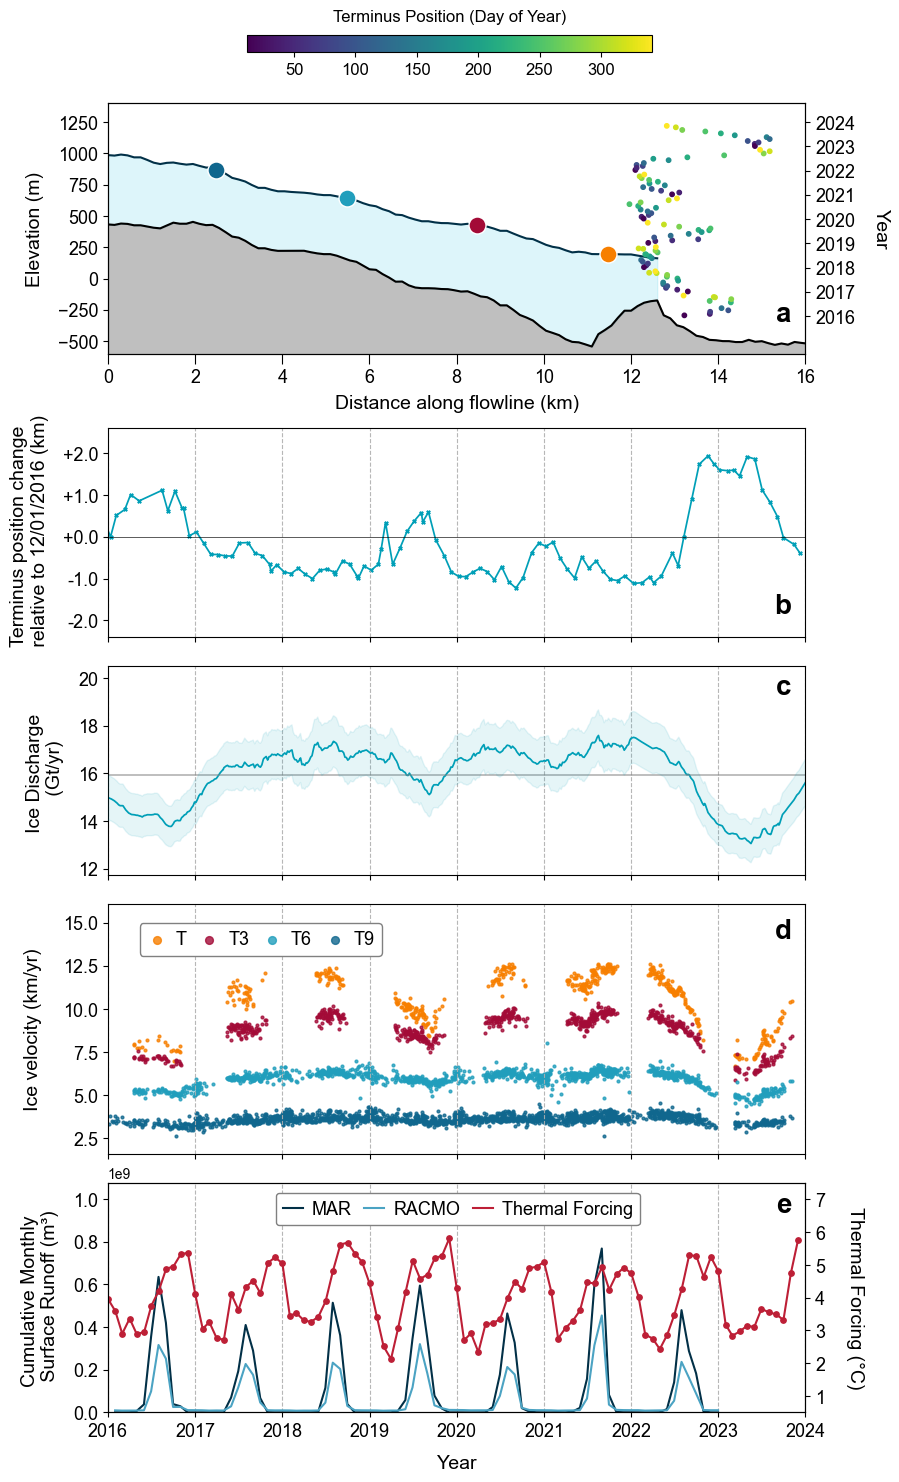

In [25]:
## Plot Figure 3 ##
print('Plotting Figure 3...')
fig = plt.figure(figsize=(9, 17))
plt.rcParams["font.family"] = "Arial"
gs = GridSpec(6, 1, height_ratios=[1.2, 0.08, 1, 1, 1.2, 1.1])

# Figure 3A - Bed & Ice Surface Elevation (BedMachine v5) & Terminus Position
ax1 = fig.add_subplot(gs[0])
ax1.plot(KBC_distance/1000, KBC_bed_elevation, color='black', label='Bed Elevation')
ax1.plot(KBC_distance/1000, KBC_surface_elevation, color='#023047', label='Surface Elevation')
ax1.set_ylabel('Elevation (m)', labelpad=10, fontsize=14)
ax1.set_xlabel('Distance along flowline (km)', labelpad=6, fontsize=14)
ax1.set_xlim(0, 6)
ax1.set_xticks(range(0, 17, 2))
ax1.set_ylim(-600, 1400)
ax1.set_yticks(range(-500, 1251, 250))
ax1.tick_params(axis='y', labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='x', length=7)
x_values = KBC_distance/1000
y1_values = [-700] * len(KBC_bed_elevation)
y2_values = KBC_bed_elevation
ax1.fill_between(x_values, y1_values, y2_values, color='gray', alpha=0.5, zorder=1)
ax1.fill_between(x_values, KBC_bed_elevation, KBC_surface_elevation, color='#90e0ef', alpha=0.3, zorder=1)
for label, (dist, elev, color) in KBC_SITES.items():
    ax1.scatter(dist/1000, elev, color=color, edgecolor='white', label=label, s=150, zorder=5)
ax1.text(0.98, 0.21, 'a', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax2 = ax1.twinx()
ax2.set_ylim(scale_start, scale_end)
ax2.set_yticks(scale_values)
ax2.set_yticklabels([str(year) for year in years])
ax2.set_ylabel('Year', rotation=270, labelpad=10, fontsize=14)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_ylabel('Year', labelpad=25, fontsize=14)
for year in years:
    year_data = KBC_terminus_timeseries[KBC_terminus_timeseries['Year'] == year]
    if not year_data.empty:
        tp_distances = year_data['distance_along_line'] / 1000
        tp_offsets = year_offsets[year] + (year_data['DOY'] / 365.0) * day_scale
        ax2.scatter(tp_distances, tp_offsets, c=year_data['DOY'], cmap='viridis', s=10, label=f'Terminus {year}')

cbar_ax = fig.add_axes([0.28, 0.91, 0.45, 0.01]) # [left, bottom, width, height]
cbar = plt.colorbar(ax2.collections[0], cax=cbar_ax, orientation='horizontal', shrink=0.4)
cbar.set_label('Terminus Position (Day of Year)', fontsize=12, labelpad=10)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_label_position('top')

# Figure 3B - Terminus Position
ax3 = fig.add_subplot(gs[2])
ax3.plot(KBC_terminus['Date'], KBC_terminus['TP_RELATIVE_TO_JAN_2016']/1000, color='#009fb7', linewidth=1.25)
ax3.scatter(KBC_terminus['Date'], KBC_terminus['TP_RELATIVE_TO_JAN_2016']/1000, color='#009fb7', s=6, marker='x')
ax3.set_ylabel(f'Terminus position change \n relative to {KBC_jan_2016_label} (km)', labelpad=10, fontsize=14)
ax3.set_ylim(-2.4, 2.6)
ax3.grid(axis='x', linestyle='--', alpha=0.9) 
ax3.set_xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2024-01-01'))
ax3.axhline(0, color='black', linewidth=0.5, linestyle='-', alpha=0.9) # Add a horizontal line at 0 (representing no change)
ax3.tick_params(axis='y', labelsize=13)
ax3.tick_params(axis='x', labelsize=13, labelbottom=False)
ax3.yaxis.set_major_formatter(FuncFormatter(y_fmt))
ax3.text(0.98, 0.21, 'b', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

# Figure 3C - Ice Discharge (Mankoff et al., 2020)
ax4 = fig.add_subplot(gs[3])
ax4.plot(KBC_discharge_date, KBC_discharge, color='#009fb7', linewidth=1.25)
ax4.fill_between(KBC_discharge_date, KBC_discharge - KBC_discharge_error, KBC_discharge + KBC_discharge_error, alpha=0.1, color='#009fb7', zorder=3)
ax4.set_ylabel('Ice Discharge \n (Gt/yr)', labelpad=10, fontsize=14)
ax4.set_xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2024-01-01'))
ax4.tick_params(axis='y', labelsize=13)
ax4.tick_params(axis='x', labelsize=13, labelbottom=False)
ax4.grid(axis='x', linestyle='--', alpha=0.9)
ax4.axhline(mean_discharge, color='gray', linestyle='-', linewidth=1.2, alpha=0.6)  # Add a horizontal line for the mean ice discharge (2016-2024)
ax4.set_ylim(11.75, 20.5)
ax4.text(0.98, 0.96, 'c', transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

# Figure 3D - Ice Velocity (ITS_LIVE)
ax5 = fig.add_subplot(gs[4])
for location, path in KBC_velocity_file_paths.items():
    df = pd.read_csv(path)
    df['mid_date'] = pd.to_datetime(df['mid_date']).dt.date  
    ax5.scatter(df['mid_date'], df[' v [m/yr]']/1000, marker='o', linestyle='None', s=4, label=f'{location}', color=sampling_location_colors[location], alpha=0.8)
ax5.set_ylabel('Ice velocity (km/yr)', labelpad=15, fontsize=14)
ax5.grid(axis='x', linestyle='--', alpha=0.9)
ax5.set_xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2024-01-01'))
ax5.tick_params(axis='y', labelsize=13)
ax5.tick_params(axis='x', labelsize=13, labelbottom=False)
ax5.set_ylim(1.6, 16.1)
ax5.legend(loc='upper left', bbox_to_anchor=(0.025, 0.98), ncol=4, frameon=True, framealpha=1, fontsize=13, markerscale=2.8, columnspacing=0.7, handletextpad=0.5, fancybox=True, borderaxespad=0.8, edgecolor='gray', handlelength=1.1)
ax5.text(0.98, 0.94, 'd', transform=ax5.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

# Figure 3E - Surface Runoff and Ocean Thermal Forcing
ax6 = fig.add_subplot(gs[5]) 
ax6.plot(KBC_mar_cumulative_volume_monthly_squeezed.time, KBC_mar_cumulative_volume_monthly_squeezed, label='MAR', linewidth=1.5, color='#023047')
ax6.plot(KBC_racmo_cumulative_volume_monthly_squeezed.time, KBC_racmo_cumulative_volume_monthly_squeezed, label='RACMO', linewidth=1.5, color='#4ba3c3')
ax6.set_ylabel('Cumulative Monthly \n Surface Runoff (m³)', labelpad=10, fontsize=14)
ax6.grid(axis='x', linestyle='--', alpha=0.9)
ax6.set_ylim(0, 1075000000)
ax6.set_xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2024-01-01'))
ax6.text(0.98, 0.96, 'e', transform=ax6.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax6.tick_params(axis='y', labelsize=13)
ax6.tick_params(axis='x', labelsize=13)
ax6.set_xlabel('Year', labelpad=10, fontsize=14)

ax6_twin = ax6.twinx()
ax6_twin.plot(data['time'], thermal_forcing_250m, label='Thermal Forcing', color='#bd1f36', linewidth=1.5)
ax6_twin.scatter(data['time'], thermal_forcing_250m, color='#bd1f36', s=15)
ax6_twin.set_ylabel('Thermal Forcing (°C)', rotation=270, labelpad=28, fontsize=14)
ax6_twin.tick_params(axis='y', labelsize=13)
ax6_twin.set_ylim(0.5, 7.5)
ax6_twin.set_yticks(range(1, 8)) 

handles1, labels1 = ax6.get_legend_handles_labels()  
handles2, labels2 = ax6_twin.get_legend_handles_labels()  
ax6.legend(handles1 + handles2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0.22, 1.02), ncol=3, frameon=True, framealpha=1, fontsize=13, markerscale=2.2, columnspacing=0.7, handletextpad=0.5, fancybox=True, borderaxespad=0.8, edgecolor='gray', handlelength=1.1)

# Save and print the figure
fig.add_subplot(gs[1]).axis('off')
plt.subplots_adjust(hspace=0.15)
plt.savefig('R:/KOGE_BUGT/github/figures/Figure_3_Koge_Bugt_Central.png', dpi=300, bbox_inches='tight')
plt.show()
